In [15]:
import os
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['ABSL_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

In [16]:
# Parameters and constants

P_tx = 0  # dBm
SNR_AVG_dB = 94 + P_tx
SNR_AVG = 10 ** (SNR_AVG_dB / 10)

MINI_BATCH_SIZE = 16
LEARNING_RATE = 5e-4

GAMMA = 0.0  # CRITICAL: No sequential dependency, MAB-oriented problem rather than MDP
EPSILON_INITIAL = 1.0
EPSILON_MIN = 0.0
MEMORY_MAX_SIZE = 500

NUM_CHANNELS = 5
NUM_USERS = 4

STATE_LEN = NUM_CHANNELS * NUM_USERS  # Only H coefficients

In [17]:
""" Libraries """

import time
from itertools import permutations
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

""" Supporting functions """

def list_maker(value, length):
    out = [value] * length
    return out

def action_space_generator(num_users, num_channels):
    action = list_maker(0, num_users)
    action_space = list(permutations(np.arange(num_channels),
                                     np.shape(action)[0]))
    return action_space

def state_space_generator(num_users, num_channels):
    action_space = action_space_generator(num_users, num_channels)
    state_space = []
    
    for action_single in action_space:
        obs = list_maker('non', num_channels)

        for action_single_element in action_single:
            obs[action_single_element] = 'U' + str(action_single.index(action_single_element))
    
        state_temp = list_maker('non', num_channels + 1)
        state_temp[:-1] = obs
        for element in obs:
            if element != 'non':
                f_J = obs.index(element)
                state_temp[-1] = 'f' + str(f_J)
                state_space.append(state_temp[:])

    return state_space

def snr_compute(action_input, snr_avg, num_users, num_channels, H, G):
    active_channels = np.zeros((num_users, num_channels))
    for ida in action_input:
        row = action_input.index(ida)
        column = ida
        active_channels[row, column] = 1

    snr_H = snr_avg * np.multiply(active_channels, abs(H) ** 2)
    snr_G = snr_avg * np.multiply(active_channels, abs(G) ** 2)

    return snr_H, snr_G

""" Create the environment """

class NetworkEnv(object):
    def __init__(self, num_of_channels, num_of_users):
        self.number_of_channels = num_of_channels
        self.number_of_users = num_of_users

        self.action_input = []
        self.state = []
        self.state_next_idx = []
        self.state_space = []
        self.obs = []
        self.state_out = []
        self.rate_temp = 0
        self.reward_out = 0
        self.rate_matrix = []

        self.H = []
        self.G = []
        self.snr_H = []
        self.snr_G = []

        self.id_channel_jammed = []
        self.f_J = []
        self.jammed_user_id = 0

        self.snr_avg = SNR_AVG

        self.action_space = action_space_generator(self.number_of_users, self.number_of_channels)
        self.state_space = state_space_generator(self.number_of_users, self.number_of_channels)

    def step(self, action_index):
        self.action_input = self.action_space[action_index]
        self.obs = list_maker('non', self.number_of_channels + 1)

        for action_input_element in self.action_input:
            self.obs[action_input_element] = 'U' + str(list(self.action_input).index(action_input_element))

        self.H = H_FIXED
        self.G = G_FIXED

        self.snr_H, self.snr_G = snr_compute(self.action_input, self.snr_avg, self.number_of_users,
                                             self.number_of_channels, self.H, self.G)

        snr_G_active = np.full_like(self.snr_G, -np.inf, dtype=float)
        for u, c in enumerate(self.action_input):
            snr_G_active[u, c] = self.snr_G[u, c]

        lin = int(np.nanargmax(snr_G_active))
        _, f_J = np.unravel_index(lin, snr_G_active.shape)
        self.f_J = int(f_J)

        self.obs[-1] = 'f' + str(self.f_J)
        self.state_out = self.obs
        self.state_next_idx = self.state_space.index(self.state_out)

        self.reward_out = 0
        self.rate_matrix = np.log2(1 + self.snr_H)
        self.rate_matrix[:, self.f_J] = 0

        self.reward_out = sum(sum(self.rate_matrix))

        return self.state_next_idx, self.reward_out, self.f_J


class DQNAgent(object):
    def __init__(self, state_size, action_space_size, learning_rate, gamma, 
                 epsilon_initial, eps_min, total_steps):
        self.state_size = state_size
        self.action_space_size = action_space_size
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon_initial
        self.epsilon_initial = epsilon_initial
        self.eps_min = eps_min
        self.total_training_steps = total_steps
        self.current_step = 0
        
        # Calculate when epsilon should reach minimum (at 95% of training)
        self.decay_end_step = int(0.95 * self.total_training_steps)
        
        self.model = self.build_model()
        
        self.q_values_history = []
        self.action_counts = np.zeros(action_space_size)
        
        self.state_batch_save = []
        self.next_state_batch_save = []
        self.action_batch_save = []
        self.Q_value_state_batch_save = []
        self.Q_value_next_state_batch_save = []

    def build_model(self):
        model = Sequential([
            Dense(256, input_dim=self.state_size, activation='relu',
                  kernel_initializer='he_normal'),
            Dropout(0.1),
            Dense(256, activation='relu',
                  kernel_initializer='he_normal'),
            Dropout(0.1),
            Dense(128, activation='relu',
                  kernel_initializer='he_normal'),
            Dense(self.action_space_size, activation='linear',
                  kernel_initializer='zeros')
        ])
        
        optimizer = Adam(learning_rate=self.lr)
        model.compile(loss='mse', optimizer=optimizer)
        return model

    def greedy_alg(self, state_full):
        if np.random.rand() <= self.epsilon:
            action = np.random.choice(self.action_space_size)
        else:
            q_values = self.model.predict(state_full.reshape(1, -1), verbose=0)[0]
            self.q_values_history.append(q_values.copy())
            action = np.argmax(q_values)
        
        self.action_counts[action] += 1
        return action

    def update_epsilon(self):
        """
        Linearly decay epsilon from initial value to minimum,
        reaching minimum at 95% of total training steps.
        
        For example, with 100 steps:
        - Step 0: epsilon = 1.0
        - Step 95: epsilon = 0.0
        - Step 96-99: epsilon = 0.0
        """
        if self.current_step >= self.decay_end_step:
            # Past 95% of training: epsilon at minimum
            self.epsilon = self.eps_min
        else:
            # Linear decay from initial to minimum over decay_end_step steps
            decay_fraction = self.current_step / self.decay_end_step
            self.epsilon = self.epsilon_initial - (self.epsilon_initial - self.eps_min) * decay_fraction
        
        self.current_step += 1

    def experience_replay(self, replay_memory, minibatch_size):
        if len(replay_memory) < minibatch_size:
            return
            
        minibatch_indices = np.random.choice(len(replay_memory), minibatch_size, replace=False)
        minibatch = [replay_memory[i] for i in minibatch_indices]

        states = np.array([x['s'] for x in minibatch])
        actions = np.array([x['a'] for x in minibatch])
        rewards = np.array([x['r'] for x in minibatch])

        self.state_batch_save = states
        self.action_batch_save = actions

        current_q = self.model.predict(states, verbose=0)
        self.Q_value_state_batch_save = current_q

        target_q = current_q.copy()
        for i in range(minibatch_size):
            target_q[i][actions[i]] = rewards[i]

        self.model.fit(states, target_q, epochs=1, verbose=0, batch_size=minibatch_size)


In [18]:
# Initialize master logs to store data across all realizations
all_realizations_log = {
    'actions': [],      # Store all actions across realizations
    'rewards': [],      # Store all rewards across realizations
    'reward_avg': [],   # Store average rewards across realizations
    'epsilon': [],      # Store epsilon values across realizations
    'max_reward': [],   # Store max reward per realization
    'convergence_step': [],  # Store convergence step per realization
    'final_action': []  # Store final selected action per realization
}

Realization 0
---------------------------------
H_FIXED:
 [[1.56943429e-04 2.76278026e-04 2.43110100e-04 1.52100402e-04
  1.97174530e-04]
 [1.26223700e-04 2.99757843e-04 1.20636741e-04 2.45381617e-04
  2.67630233e-04]
 [1.10112983e-04 1.73824063e-04 2.56206500e-04 1.54372662e-04
  1.54437981e-04]
 [1.20068313e-04 8.60436665e-05 9.24309514e-05 1.05569804e-04
  8.40962120e-05]]
G_FIXED:
 [[0.00012658 0.00015122 0.00012135 0.000207   0.00023843]
 [0.00014719 0.00017199 0.00023959 0.00017051 0.00019364]
 [0.00031584 0.00040846 0.00016236 0.00026243 0.00028023]
 [0.00177944 0.00101481 0.00150301 0.00121751 0.0016922 ]]
Step 100/500 | Eps: 0.792 | Avg(100): 19.42 | Max: 22.46
Step 200/500 | Eps: 0.581 | Avg(100): 20.07 | Max: 22.46
Step 300/500 | Eps: 0.371 | Avg(100): 21.07 | Max: 22.46
Step 400/500 | Eps: 0.160 | Avg(100): 21.40 | Max: 22.46
Step 500/500 | Eps: 0.000 | Avg(100): 22.29 | Max: 22.46

Realization 0 Results:
  Max reward: 22.4637
  Final reward: 22.4637
  Avg reward: 20.8553
 

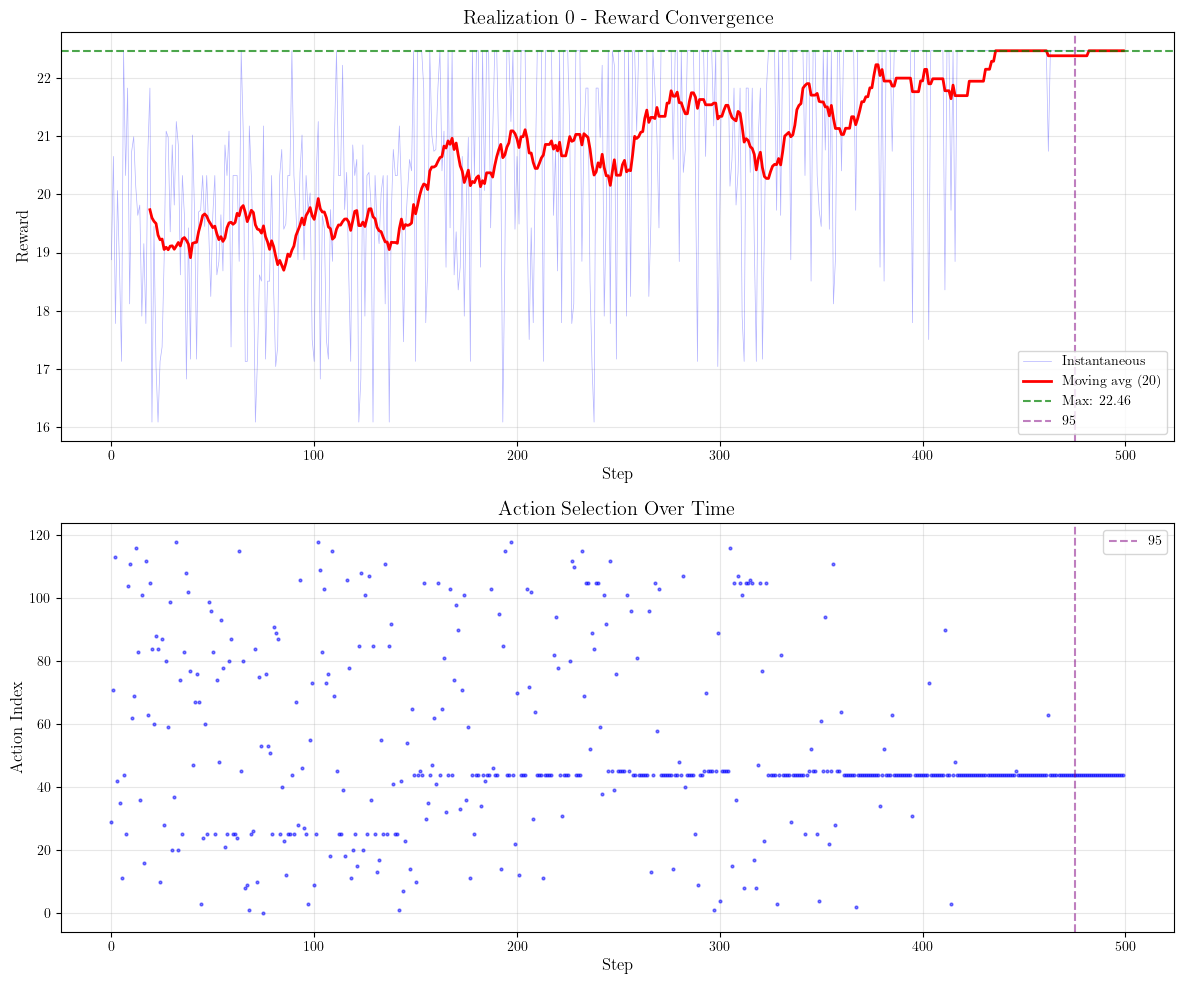

Realization 1
---------------------------------
H_FIXED:
 [[3.95263610e-04 1.94910290e-04 2.93513944e-04 1.79481407e-04
  3.05478154e-04]
 [2.08783639e-04 1.38216015e-04 2.56253713e-04 2.48143248e-04
  2.79905585e-04]
 [1.92244487e-04 7.24358492e-05 1.29900332e-04 1.32229451e-04
  8.75150774e-05]
 [6.21478397e-05 8.74792911e-05 7.75951767e-05 1.01069403e-04
  4.86101660e-05]]
G_FIXED:
 [[1.65655606e-04 2.29771672e-04 2.07944284e-04 8.67138156e-05
  2.08689674e-04]
 [1.97944871e-04 1.23919836e-04 1.60686913e-04 2.34675559e-04
  1.74472130e-04]
 [2.93023727e-04 4.77094212e-04 4.61780251e-04 3.92902819e-04
  2.23224079e-04]
 [1.30474928e-03 1.50736843e-03 1.98576820e-03 2.27723485e-03
  1.84849604e-03]]
Step 100/500 | Eps: 0.792 | Avg(100): 19.46 | Max: 21.94
Step 200/500 | Eps: 0.581 | Avg(100): 19.86 | Max: 21.94
Step 300/500 | Eps: 0.371 | Avg(100): 20.82 | Max: 21.94
Step 400/500 | Eps: 0.160 | Avg(100): 21.09 | Max: 21.94
Step 500/500 | Eps: 0.000 | Avg(100): 21.56 | Max: 21.94

Real

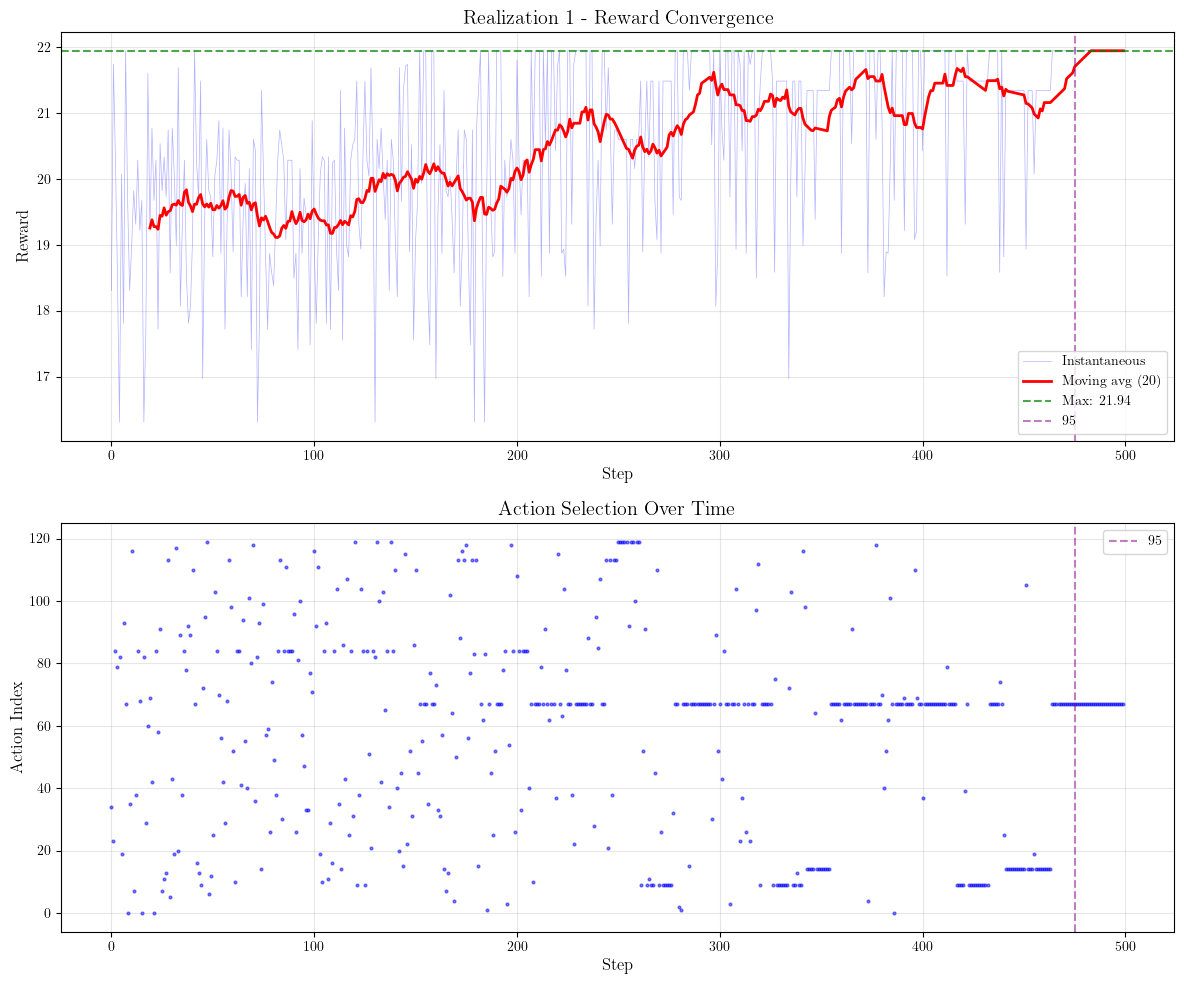

Realization 2
---------------------------------
H_FIXED:
 [[1.68313943e-04 2.11320796e-04 1.75570371e-04 1.67077990e-04
  2.56779868e-04]
 [2.68288011e-04 1.79899404e-04 2.26240021e-04 3.37528605e-04
  1.84171753e-04]
 [1.63004244e-04 1.05723545e-04 2.55741187e-04 2.28619567e-04
  1.08308487e-04]
 [1.46622103e-04 1.43355873e-04 1.29707892e-04 1.32646888e-04
  8.74608648e-05]]
G_FIXED:
 [[0.00013012 0.00016234 0.00017335 0.00011393 0.00013898]
 [0.00017852 0.00013169 0.00023301 0.00016645 0.00011599]
 [0.00031953 0.00028011 0.00025419 0.0003412  0.00026988]
 [0.00194363 0.00185285 0.00145151 0.0020842  0.00225095]]


Step 100/500 | Eps: 0.792 | Avg(100): 19.61 | Max: 22.92
Step 200/500 | Eps: 0.581 | Avg(100): 20.51 | Max: 22.92
Step 300/500 | Eps: 0.371 | Avg(100): 20.61 | Max: 22.92
Step 400/500 | Eps: 0.160 | Avg(100): 21.97 | Max: 22.92
Step 500/500 | Eps: 0.000 | Avg(100): 22.83 | Max: 22.92

Realization 2 Results:
  Max reward: 22.9150
  Final reward: 22.9150
  Avg reward: 21.1113
  Final epsilon: 0.0000
  Epsilon at 95% step: 0.0021
  Most frequent action: 0
  Q-max (last 10): 23.54
  Best Q action: 118
  Action exploration: 94/120 tried
Last action: (4, 3, 2, 0)
Jammed channel: f0
Rate matrix:
 [[0.         0.         0.         0.         7.38044803]
 [0.         0.         0.         8.16575151 0.        ]
 [0.         0.         7.36882335 0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Last reward: 22.9150


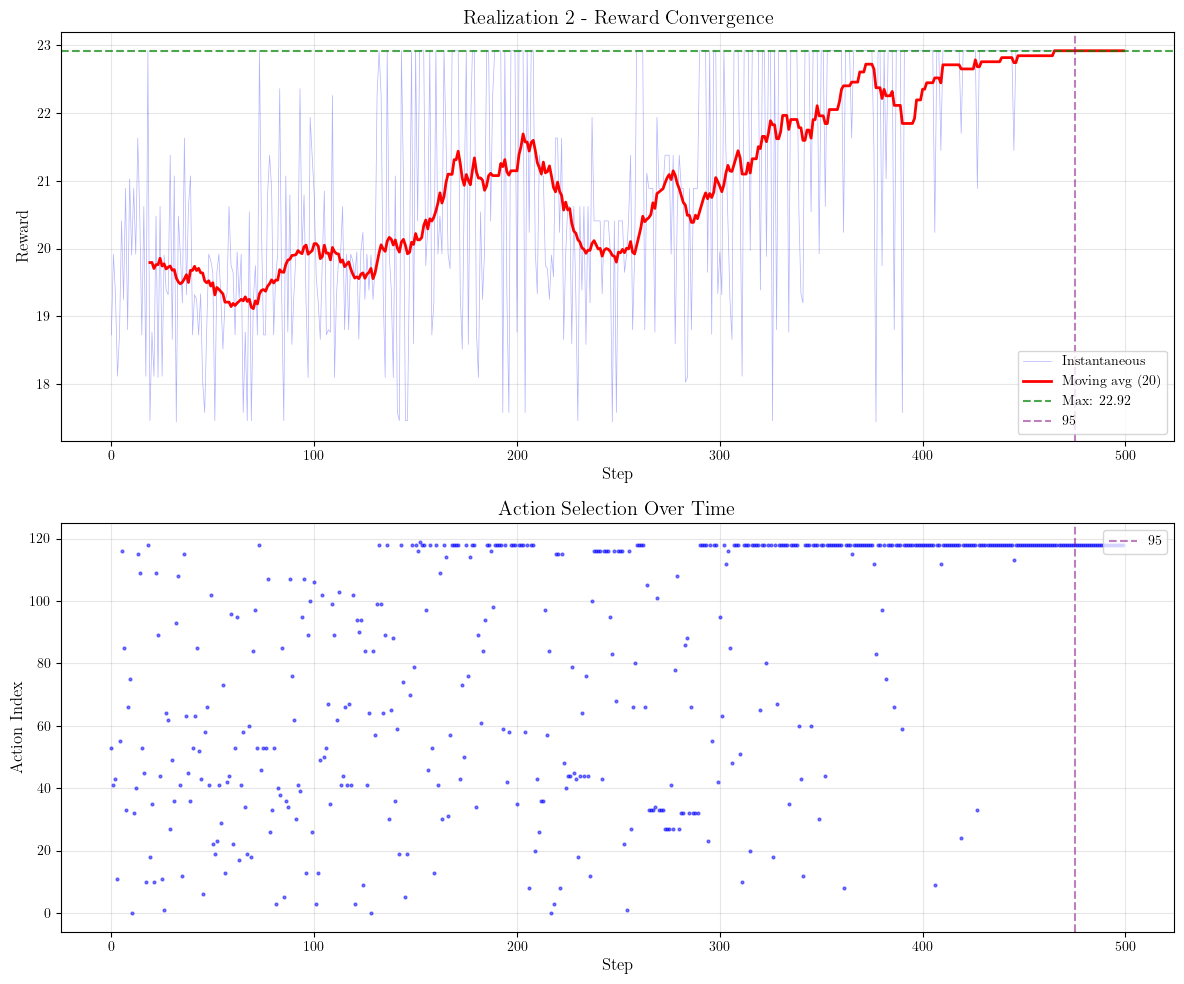

Realization 3
---------------------------------
H_FIXED:
 [[8.69554600e-05 2.30826302e-04 3.45435648e-04 1.32903402e-04
  1.76716556e-04]
 [2.56109145e-04 8.07835758e-05 2.08391492e-04 2.30509996e-04
  2.05431870e-04]
 [1.56894706e-04 1.72861901e-04 2.40114314e-04 1.08033523e-04
  1.37647798e-04]
 [9.25917963e-05 1.07081955e-04 1.09439013e-04 9.33387531e-05
  1.21246932e-04]]
G_FIXED:
 [[2.10420206e-04 6.86324392e-05 1.27404317e-04 1.42888704e-04
  1.81808543e-04]
 [2.79139380e-04 2.68811522e-04 1.61159834e-04 2.34707793e-04
  1.60806758e-04]
 [3.08225280e-04 3.66418944e-04 3.14614610e-04 4.30502770e-04
  1.43676441e-04]
 [1.29506628e-03 1.94724957e-03 6.60000909e-04 1.44798685e-03
  2.79299053e-03]]


Step 100/500 | Eps: 0.792 | Avg(100): 18.63 | Max: 21.64
Step 200/500 | Eps: 0.581 | Avg(100): 19.41 | Max: 21.64
Step 300/500 | Eps: 0.371 | Avg(100): 20.12 | Max: 21.64
Step 400/500 | Eps: 0.160 | Avg(100): 20.51 | Max: 21.64
Step 500/500 | Eps: 0.000 | Avg(100): 21.14 | Max: 21.64

Realization 3 Results:
  Max reward: 21.6361
  Final reward: 21.5525
  Avg reward: 19.9665
  Final epsilon: 0.0000
  Epsilon at 95% step: 0.0021
  Most frequent action: 0
  Q-max (last 10): 21.96
  Best Q action: 63
  Action exploration: 101/120 tried
Last action: (2, 3, 1, 4)
Jammed channel: f4
Rate matrix:
 [[0.         0.         8.23233854 0.         0.        ]
 [0.         0.         0.         7.07112691 0.        ]
 [0.         6.24903329 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Last reward: 21.5525


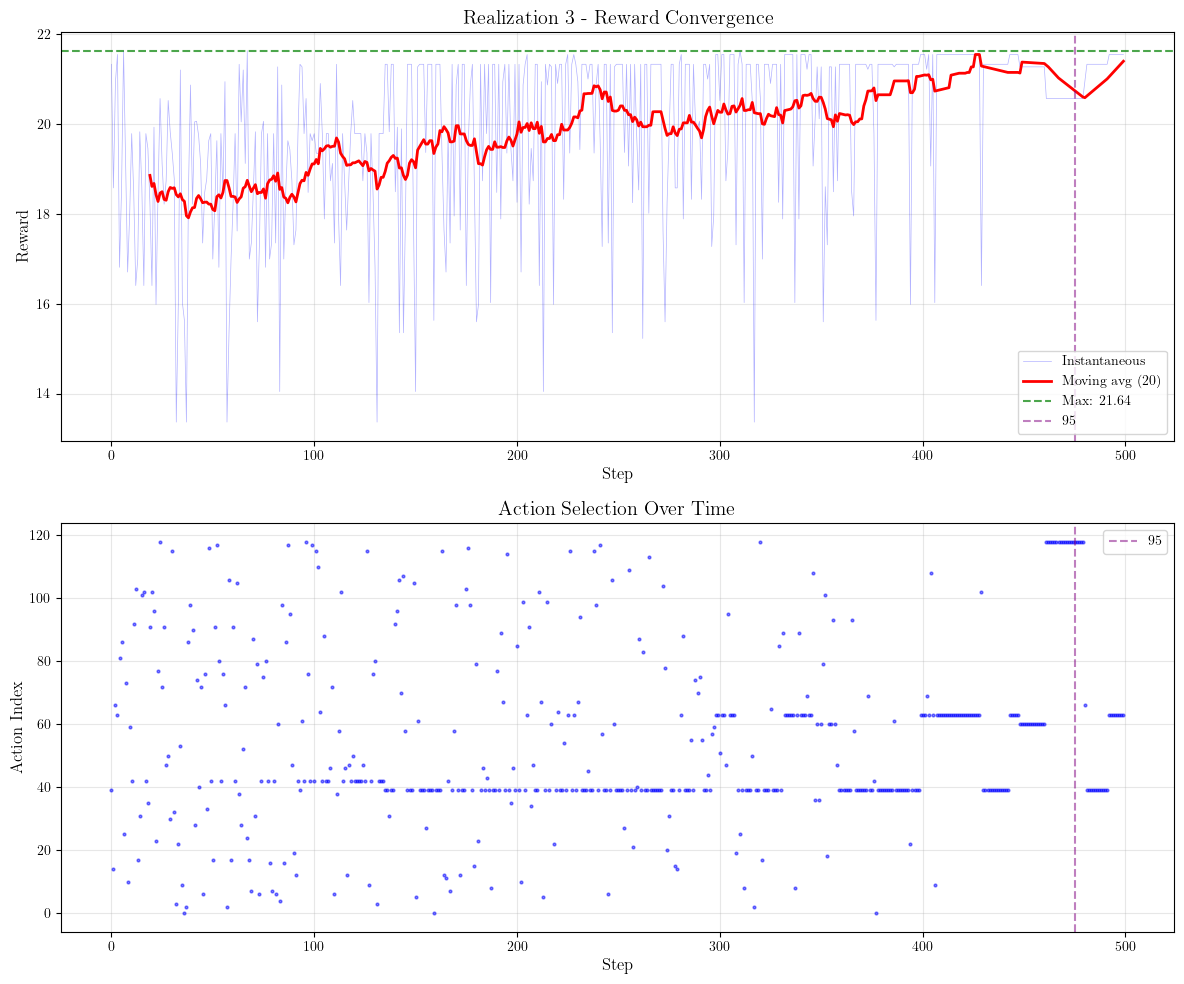

Realization 4
---------------------------------
H_FIXED:
 [[1.26562732e-04 2.33548241e-04 1.68098068e-04 2.08309028e-04
  2.29913424e-04]
 [2.54509326e-04 2.28756633e-04 1.97057880e-04 3.20833424e-04
  3.71237045e-04]
 [2.07138175e-04 2.00964557e-04 1.47801119e-04 1.98934421e-04
  1.29875878e-04]
 [8.06019898e-05 7.68249842e-05 9.20259962e-05 1.17295554e-04
  8.43885235e-05]]
G_FIXED:
 [[1.91273975e-04 1.64458383e-04 2.31461005e-04 1.08056932e-04
  8.88184088e-05]
 [1.48163380e-04 1.08290336e-04 1.76509426e-04 2.16115217e-04
  1.16098430e-04]
 [2.83929016e-04 2.89124987e-04 3.16291429e-04 2.72141721e-04
  3.44785818e-04]
 [1.61799747e-03 1.58622738e-03 2.11952905e-03 1.53497959e-03
  1.69568261e-03]]
Step 100/500 | Eps: 0.792 | Avg(100): 20.15 | Max: 22.20
Step 200/500 | Eps: 0.581 | Avg(100): 20.70 | Max: 22.31
Step 300/500 | Eps: 0.371 | Avg(100): 21.13 | Max: 22.31
Step 400/500 | Eps: 0.160 | Avg(100): 21.83 | Max: 22.31
Step 500/500 | Eps: 0.000 | Avg(100): 21.98 | Max: 22.31

Real

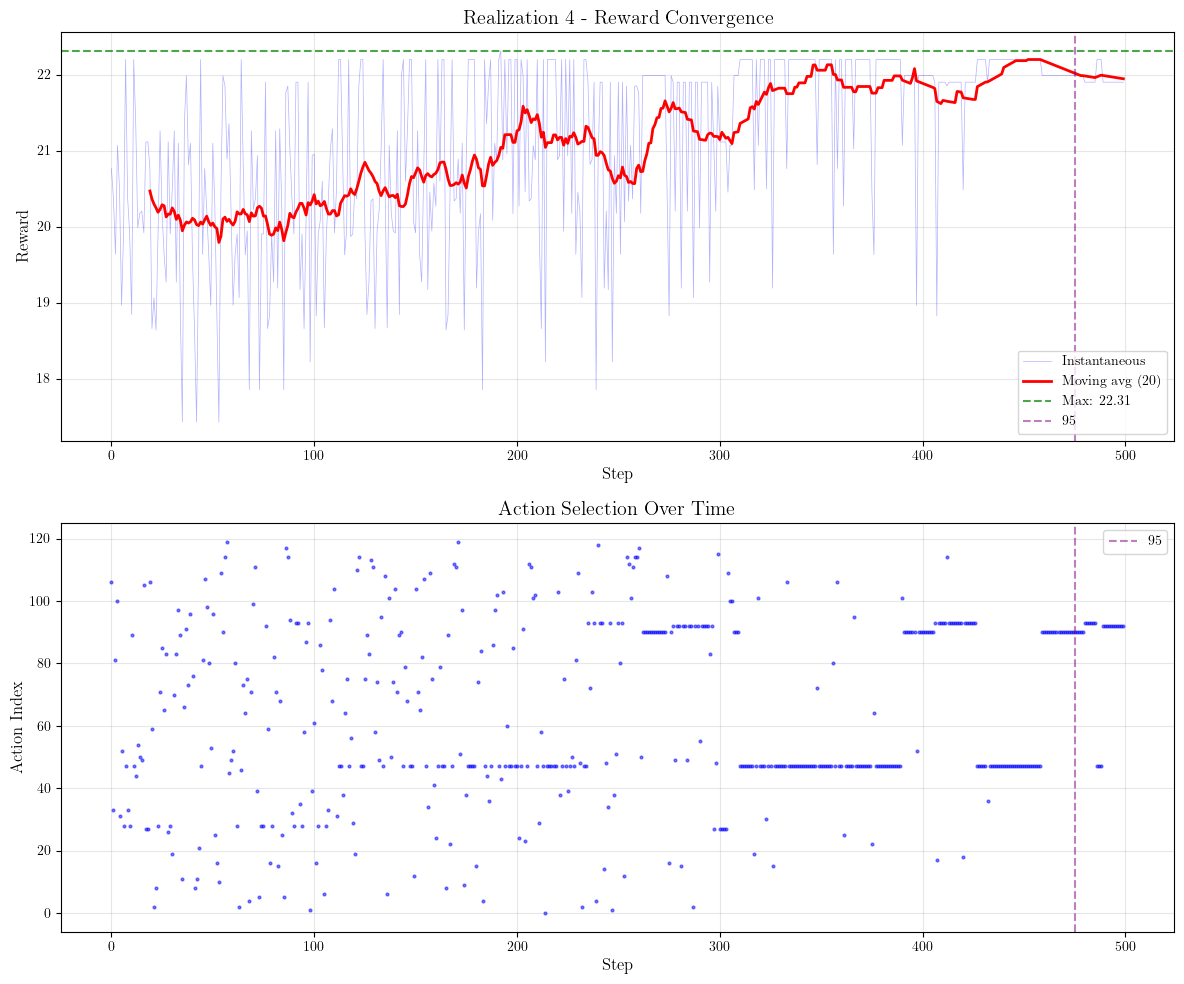


TRAINING COMPLETE
Total time: 109.67 seconds

Overall Statistics:
  Avg of all rewards: 20.73189
  Max of all rewards: 22.91502
  Final avg reward: 21.16303


In [19]:

NUM_REALIZATIONS = 5
NUM_INDIVIDUAL_LOOPS = 500

H_all_dict = scipy.io.loadmat('./data_H_all.mat')
H_all = H_all_dict['H_all']
G_all_dict = scipy.io.loadmat('./data_G_all.mat')
G_all = G_all_dict['G_all']

env = NetworkEnv(num_of_channels=NUM_CHANNELS, num_of_users=NUM_USERS)

all_rewards = []
all_actions = []
all_avg_rewards = []

start = time.time()

for ss in np.arange(NUM_REALIZATIONS):
    
    print(f'Realization {ss}')
    print(f'{"-"*33}')
    
    H_single_vec = H_all[ss]
    H_FIXED = H_single_vec.reshape(NUM_USERS, NUM_CHANNELS)
    G_single_vec = G_all[ss]
    G_FIXED = G_single_vec.reshape(NUM_USERS, NUM_CHANNELS)
    
    print('H_FIXED:\n', H_FIXED)
    print('G_FIXED:\n', G_FIXED)
    
    action_log = []
    reward_log = []
    reward_avg_log = []
    epsilon_log = []
    
    replay_memory = []
    
    # Create new agent for each realization
    agent = DQNAgent(
        state_size=STATE_LEN,
        action_space_size=len(env.action_space),
        learning_rate=LEARNING_RATE,
        gamma=GAMMA,
        epsilon_initial=EPSILON_INITIAL,
        eps_min=EPSILON_MIN,
        total_steps=NUM_INDIVIDUAL_LOOPS
    )
    
    state_full = H_single_vec.flatten()
    
    for step_inner in range(NUM_INDIVIDUAL_LOOPS):
        
        # Update epsilon at the start of each step
        agent.update_epsilon()
        epsilon_log.append(agent.epsilon)
        
        if (step_inner + 1) % 100 == 0:
            recent_rewards = reward_log[-100:] if len(reward_log) >= 100 else reward_log
            print(f'Step {step_inner+1}/{NUM_INDIVIDUAL_LOOPS} | '
                  f'Eps: {agent.epsilon:.3f} | '
                  f'Avg(100): {np.mean(recent_rewards):.2f} | '
                  f'Max: {np.max(reward_log) if reward_log else 0:.2f}')
        
        action_idx = agent.greedy_alg(state_full)
        
        state_next_idx, reward, f_J = env.step(action_idx)
        
        replay_memory.append({
            "s": state_full, 
            "a": action_idx, 
            "r": reward, 
            "s_next": state_full
        })
        
        if len(replay_memory) > MEMORY_MAX_SIZE:
            replay_memory.pop(0)
        
        if len(replay_memory) >= MINI_BATCH_SIZE:
            agent.experience_replay(replay_memory, MINI_BATCH_SIZE)
        
        action_log.append(action_idx)
        reward_log.append(reward)
        reward_avg = np.mean(reward_log)
        reward_avg_log.append(reward_avg)
    
    all_rewards.extend(reward_log)
    all_actions.extend(action_log)
    all_avg_rewards.extend(reward_avg_log)
    
    max_reward = np.max(reward_log)
    final_reward = reward_log[-1]
    best_action = np.argmax([reward_log.count(i) for i in range(len(env.action_space))])
    
    # After training, append to master logs
    all_realizations_log['actions'].append(action_log)
    all_realizations_log['rewards'].append(reward_log)
    all_realizations_log['reward_avg'].append(reward_avg_log)
    all_realizations_log['epsilon'].append(epsilon_log)
    all_realizations_log['max_reward'].append(max(reward_log))
    all_realizations_log['final_action'].append(action_log[-1])
    
    ## PRINT
    
    print(f'\nRealization {ss} Results:')
    print(f'  Max reward: {max_reward:.4f}')
    print(f'  Final reward: {final_reward:.4f}')
    print(f'  Avg reward: {reward_avg:.4f}')
    print(f'  Final epsilon: {agent.epsilon:.4f}')
    print(f'  Epsilon at 95% step: {epsilon_log[agent.decay_end_step-1]:.4f}')
    print(f'  Most frequent action: {best_action}')
    
    if len(agent.q_values_history) > 10:
        recent_q = agent.q_values_history[-10:]
        avg_q_max = np.mean([np.max(q) for q in recent_q])
        best_q_action = np.argmax(agent.q_values_history[-1])
        print(f'  Q-max (last 10): {avg_q_max:.2f}')
        print(f'  Best Q action: {best_q_action}')
        print(f'  Action exploration: {np.count_nonzero(agent.action_counts)}/{len(env.action_space)} tried')
    
    print('Last action:', env.action_space[action_idx])
    print(f'Jammed channel: f{env.f_J}')
    print('Rate matrix:\n', env.rate_matrix)
    print(f'Last reward: {reward:.4f}')
    
    plt.close('all')
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Reward plot
    x1 = np.arange(len(reward_log))
    ax1.plot(x1, reward_log, 'b-', alpha=0.3, linewidth=0.5, label='Instantaneous')
    
    window = 20
    if len(reward_log) >= window:
        moving_avg = np.convolve(reward_log, np.ones(window)/window, mode='valid')
        ax1.plot(np.arange(window-1, len(reward_log)), moving_avg, 'r-', 
                linewidth=2, label=f'Moving avg ({window})')
    
    ax1.axhline(y=max_reward, color='g', linestyle='--', alpha=0.7,
                label=f'Max: {max_reward:.2f}')
    ax1.axvline(x=agent.decay_end_step, color='purple', linestyle='--', alpha=0.5,
                label=f'95% step: {agent.decay_end_step}')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Reward')
    ax1.set_title(f"Realization {ss} - Reward Convergence")
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # Action plot
    ax2.plot(x1, action_log, 'bo', markersize=2, alpha=0.5)
    ax2.axvline(x=agent.decay_end_step, color='purple', linestyle='--', alpha=0.5,
                label=f'95% step: {agent.decay_end_step}')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Action Index')
    ax2.set_title(f"Action Selection Over Time")
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    agent.model.save(f'model_fixed_{ss}.h5')

elapsed = time.time() - start

print(f'\n{"="*33}')
print('TRAINING COMPLETE')
print(f'{"="*60}')
print(f'Total time: {elapsed:.2f} seconds')
print(f'\nOverall Statistics:')
print(f'  Avg of all rewards: {np.mean(all_rewards):.5f}')
print(f'  Max of all rewards: {np.max(all_rewards):.5f}')
print(f'  Final avg reward: {all_avg_rewards[-1]:.5f}')

In [20]:
# Convert to numpy arrays for easier analysis
all_realizations_log['max_reward'] = np.array(all_realizations_log['max_reward'])
all_realizations_log['convergence_step'] = np.array(all_realizations_log['convergence_step'])
all_realizations_log['final_action'] = np.array(all_realizations_log['final_action'])

# Summary statistics across all realizations
print('SUMMARY ACROSS ALL REALIZATIONS')
print(f'Average Max Reward: {np.mean(all_realizations_log["max_reward"]):.4f} ± {np.std(all_realizations_log["max_reward"]):.4f}')

SUMMARY ACROSS ALL REALIZATIONS
Average Max Reward: 22.2545 ± 0.4387


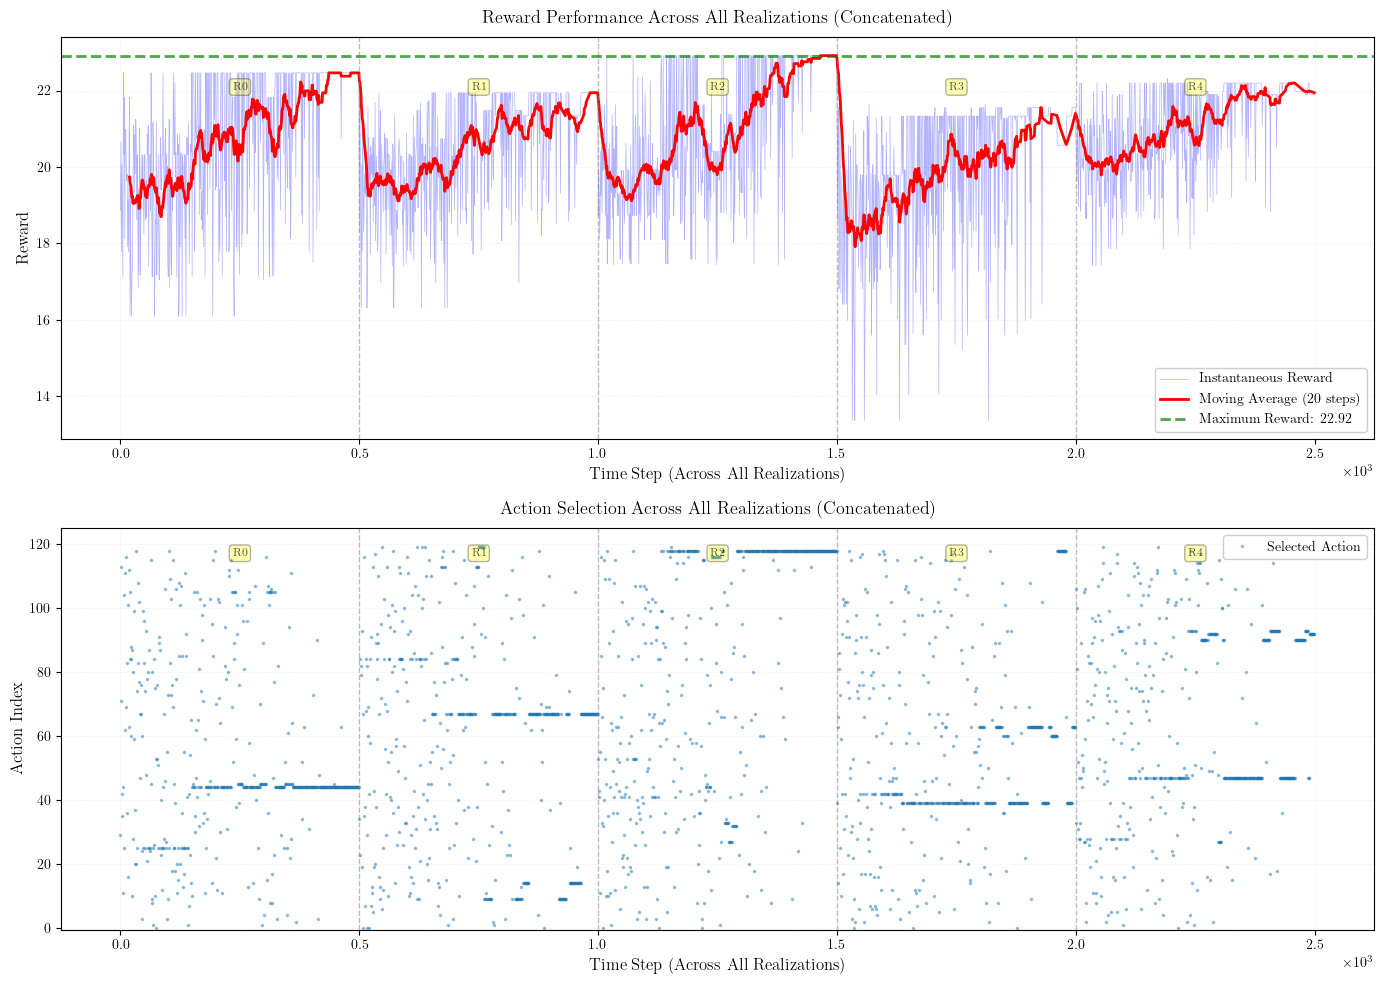


SUMMARY ACROSS ALL REALIZATIONS
Total Time Steps: 2,500
Number of Realizations: 5
Average Steps per Realization: 500
Max Reward (mean ± std): 22.2545 ± 0.4387
Overall Max Reward: 22.9150
Final Reward (mean of last window steps): 21.9789


In [21]:
plt.close('all')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))


# SUBPLOT 1: Concatenated rewards over all realizations

# Concatenate all rewards across realizations
all_rewards_concat = []
all_actions_concat = []
realization_boundaries = [0]

for ss in range(NUM_REALIZATIONS):
    all_rewards_concat.extend(all_realizations_log['rewards'][ss])
    all_actions_concat.extend(all_realizations_log['actions'][ss])
    realization_boundaries.append(len(all_rewards_concat))

time_steps = np.arange(len(all_rewards_concat))

# Plot instantaneous rewards
ax1.plot(time_steps, all_rewards_concat, 'b-', alpha=0.3, linewidth=0.5, label='Instantaneous Reward')

# Plot moving average
window = 20
if len(all_rewards_concat) >= window:
    moving_avg = np.convolve(all_rewards_concat, np.ones(window)/window, mode='valid')
    ax1.plot(np.arange(window-1, len(all_rewards_concat)), moving_avg, 'r-', 
            linewidth=2, label=f'Moving Average ({window} steps)')

# Add vertical lines to separate realizations
for boundary in realization_boundaries[1:-1]:
    ax1.axvline(x=boundary, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Add max reward line
overall_max = np.max(all_realizations_log['max_reward'])
ax1.axhline(y=overall_max, color='g', linestyle='--', linewidth=2, alpha=0.7,
            label=f'Maximum Reward: {overall_max:.2f}')

ax1.set_xlabel('Time Step (Across All Realizations)', fontsize=12)
ax1.set_ylabel('Reward', fontsize=12)
ax1.set_title('Reward Performance Across All Realizations (Concatenated)', 
              fontsize=13, pad=10, fontweight='bold')
ax1.legend(loc='lower right', framealpha=0.95, fontsize=10)
ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
ax1.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Add realization labels
for ss in range(NUM_REALIZATIONS):
    mid_point = (realization_boundaries[ss] + realization_boundaries[ss+1]) / 2
    ax1.text(mid_point, ax1.get_ylim()[1] * 0.95, f'R{ss}', 
            ha='center', va='top', fontsize=8, alpha=0.7,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))


# SUBPLOT 2: Concatenated actions over all realizations

ax2.plot(time_steps, all_actions_concat, 'o', color='#1f77b4', 
         markersize=1.5, alpha=0.4, label='Selected Action')

# Add vertical lines to separate realizations
for boundary in realization_boundaries[1:-1]:
    ax2.axvline(x=boundary, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax2.set_xlabel('Time Step (Across All Realizations)', fontsize=12)
ax2.set_ylabel('Action Index', fontsize=12)
ax2.set_title('Action Selection Across All Realizations (Concatenated)', 
              fontsize=13, pad=10, fontweight='bold')
ax2.legend(loc='upper right', framealpha=0.95, fontsize=10)
ax2.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
ax2.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
ax2.set_ylim(bottom=-0.5)

# Add realization labels
for ss in range(NUM_REALIZATIONS):
    mid_point = (realization_boundaries[ss] + realization_boundaries[ss+1]) / 2
    ax2.text(mid_point, ax2.get_ylim()[1] * 0.95, f'R{ss}', 
            ha='center', va='top', fontsize=8, alpha=0.7,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.show()

# Print summary statistics
print(f'\n{"="*33}')
print('SUMMARY ACROSS ALL REALIZATIONS')
print(f'{"="*33}')
print(f'Total Time Steps: {len(all_rewards_concat):,}')
print(f'Number of Realizations: {NUM_REALIZATIONS}')
print(f'Average Steps per Realization: {len(all_rewards_concat)/NUM_REALIZATIONS:.0f}')
print(f'Max Reward (mean ± std): {np.mean(all_realizations_log["max_reward"]):.4f} ± {np.std(all_realizations_log["max_reward"]):.4f}')
print(f'Overall Max Reward: {overall_max:.4f}')
print(f'Final Reward (mean of last window steps): {np.mean(all_rewards_concat[-100:]):.4f}')

# Save to .mat file

In [22]:
import scipy.io as sio

# Prepare data for MATLAB (convert lists to arrays)
mat_data = {
    'NUM_REALIZATIONS': NUM_REALIZATIONS,
    'num_steps_per_realization': np.array([len(all_realizations_log['rewards'][i]) 
                                            for i in range(NUM_REALIZATIONS)]),
    'max_reward': np.array(all_realizations_log['max_reward']),
    'convergence_step': np.array(all_realizations_log['convergence_step']),
    'final_action': np.array(all_realizations_log['final_action'])
}

# Save individual realization data
for ss in range(NUM_REALIZATIONS):
    mat_data[f'rewards_r{ss}'] = np.array(all_realizations_log['rewards'][ss])
    mat_data[f'actions_r{ss}'] = np.array(all_realizations_log['actions'][ss])
    
    if all_realizations_log['reward_avg']:  # if exists
        mat_data[f'reward_avg_r{ss}'] = np.array(all_realizations_log['reward_avg'][ss])
    
    if all_realizations_log['epsilon']:  # if exists
        mat_data[f'epsilon_r{ss}'] = np.array(all_realizations_log['epsilon'][ss])

# Save to .mat file
sio.savemat('all_realizations_log.mat', mat_data)
print('Data saved to all_realizations_log.mat')

Data saved to all_realizations_log.mat


Plotting realization: 1


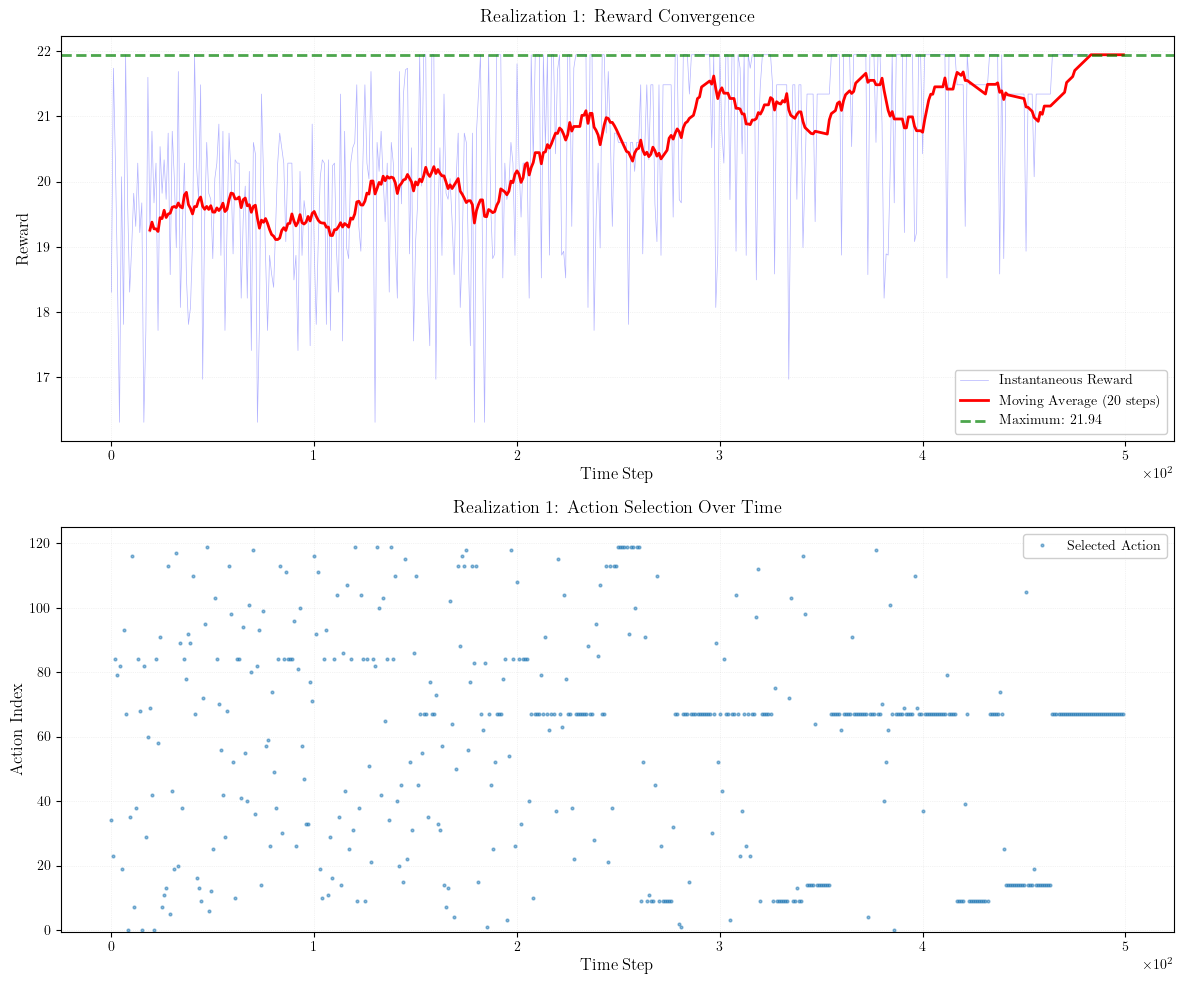

In [23]:
import numpy as np
import matplotlib.pyplot as plt


# PLOT 1: Single Random Realization

plt.close('all')

# Select a random realization
random_realization = np.random.randint(0, NUM_REALIZATIONS)
print(f'Plotting realization: {random_realization}')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Get data for this realization
rewards = all_realizations_log['rewards'][random_realization]
actions = all_realizations_log['actions'][random_realization]
time_steps = np.arange(len(rewards))

# Reward plot
ax1.plot(time_steps, rewards, 'b-', alpha=0.3, linewidth=0.5, label='Instantaneous Reward')

# Moving average
window = 20
if len(rewards) >= window:
    moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
    ax1.plot(np.arange(window-1, len(rewards)), moving_avg, 'r-', 
            linewidth=2, label=f'Moving Average ({window} steps)')

# Max reward line
max_reward_single = all_realizations_log['max_reward'][random_realization]
ax1.axhline(y=max_reward_single, color='g', linestyle='--', linewidth=2, alpha=0.7,
            label=f'Maximum: {max_reward_single:.2f}')

ax1.set_xlabel('Time Step', fontsize=12)
ax1.set_ylabel('Reward', fontsize=12)
ax1.set_title(f'Realization {random_realization}: Reward Convergence', 
              fontsize=13, pad=10, fontweight='bold')
ax1.legend(loc='lower right', framealpha=0.95, fontsize=10)
ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
ax1.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Action plot
ax2.plot(time_steps, actions, 'o', color='#1f77b4', markersize=2, alpha=0.5, 
         label='Selected Action')

ax2.set_xlabel('Time Step', fontsize=12)
ax2.set_ylabel('Action Index', fontsize=12)
ax2.set_title(f'Realization {random_realization}: Action Selection Over Time', 
              fontsize=13, pad=10, fontweight='bold')
ax2.legend(loc='upper right', framealpha=0.95, fontsize=10)
ax2.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
ax2.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
ax2.set_ylim(bottom=-0.5)

plt.tight_layout()
plt.show()
# 

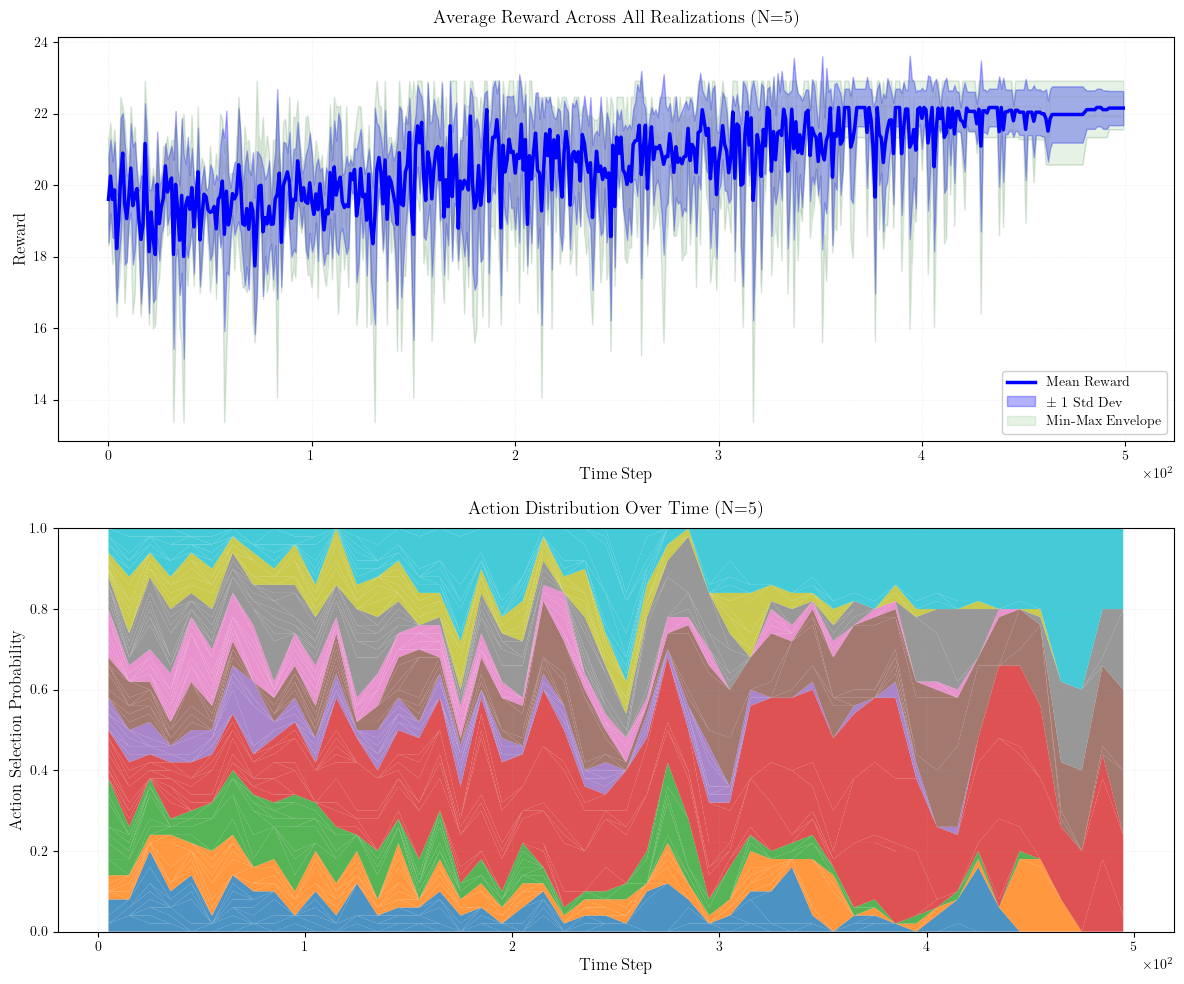

In [24]:

# PLOT 2: Average Over All Realizations

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Find minimum length across all realizations
min_length = min([len(all_realizations_log['rewards'][i]) for i in range(NUM_REALIZATIONS)])

# Truncate all trajectories to minimum length
rewards_matrix = np.array([all_realizations_log['rewards'][i][:min_length] 
                           for i in range(NUM_REALIZATIONS)])
actions_matrix = np.array([all_realizations_log['actions'][i][:min_length] 
                          for i in range(NUM_REALIZATIONS)])

time_steps = np.arange(min_length)


# Reward subplot

# Calculate statistics
mean_rewards = np.mean(rewards_matrix, axis=0)
std_rewards = np.std(rewards_matrix, axis=0)
min_rewards = np.min(rewards_matrix, axis=0)
max_rewards_envelope = np.max(rewards_matrix, axis=0)

# Plot individual trajectories (faint)
for ss in range(NUM_REALIZATIONS):
    ax1.plot(time_steps, rewards_matrix[ss], alpha=0.15, linewidth=0.8, color='gray')

# Plot mean and confidence interval
ax1.plot(time_steps, mean_rewards, 'b-', linewidth=2.5, label='Mean Reward')
ax1.fill_between(time_steps, 
                  mean_rewards - std_rewards, 
                  mean_rewards + std_rewards,
                  alpha=0.3, color='blue', label='± 1 Std Dev')

# Add envelope (min/max)
ax1.fill_between(time_steps, min_rewards, max_rewards_envelope,
                  alpha=0.1, color='green', label='Min-Max Envelope')

# # Overall max reward line
# overall_max = np.max(all_realizations_log['max_reward'])
# ax1.axhline(y=overall_max, color='r', linestyle='--', linewidth=2, 
#             alpha=0.7, label=f'Overall Max: {overall_max:.2f}')

ax1.set_xlabel('Time Step', fontsize=12)
ax1.set_ylabel('Reward', fontsize=12)
ax1.set_title(f'Average Reward Across All Realizations (N={NUM_REALIZATIONS})', 
              fontsize=13, pad=10, fontweight='bold')
ax1.legend(loc='lower right', framealpha=0.95, fontsize=10)
ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
ax1.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))


# Action subplot - Show action distribution over time

# Create action histogram over time
num_actions = int(np.max(actions_matrix)) + 1
time_bins = 50

bin_edges = np.linspace(0, min_length, time_bins + 1)
action_counts = np.zeros((num_actions, time_bins))

for t_idx in range(time_bins):
    t_start = int(bin_edges[t_idx])
    t_end = int(bin_edges[t_idx + 1])
    
    for ss in range(NUM_REALIZATIONS):
        actions_in_bin = actions_matrix[ss, t_start:t_end]
        for action in actions_in_bin:
            action_counts[int(action), t_idx] += 1

# Normalize to get probabilities
action_probs = action_counts / (NUM_REALIZATIONS * (bin_edges[1] - bin_edges[0]))

# Plot as stacked area chart
# Plot as stacked area chart without legend
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
colors = plt.cm.tab10(np.linspace(0, 1, num_actions))

ax2.stackplot(bin_centers, action_probs,
              colors=colors, alpha=0.8)

ax2.set_xlabel('Time Step', fontsize=12)
ax2.set_ylabel('Action Selection Probability', fontsize=12)
ax2.set_title(f'Action Distribution Over Time (N={NUM_REALIZATIONS})', 
              fontsize=13, pad=10, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
ax2.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
ax2.set_ylim([0, 1])


plt.tight_layout()
plt.show()


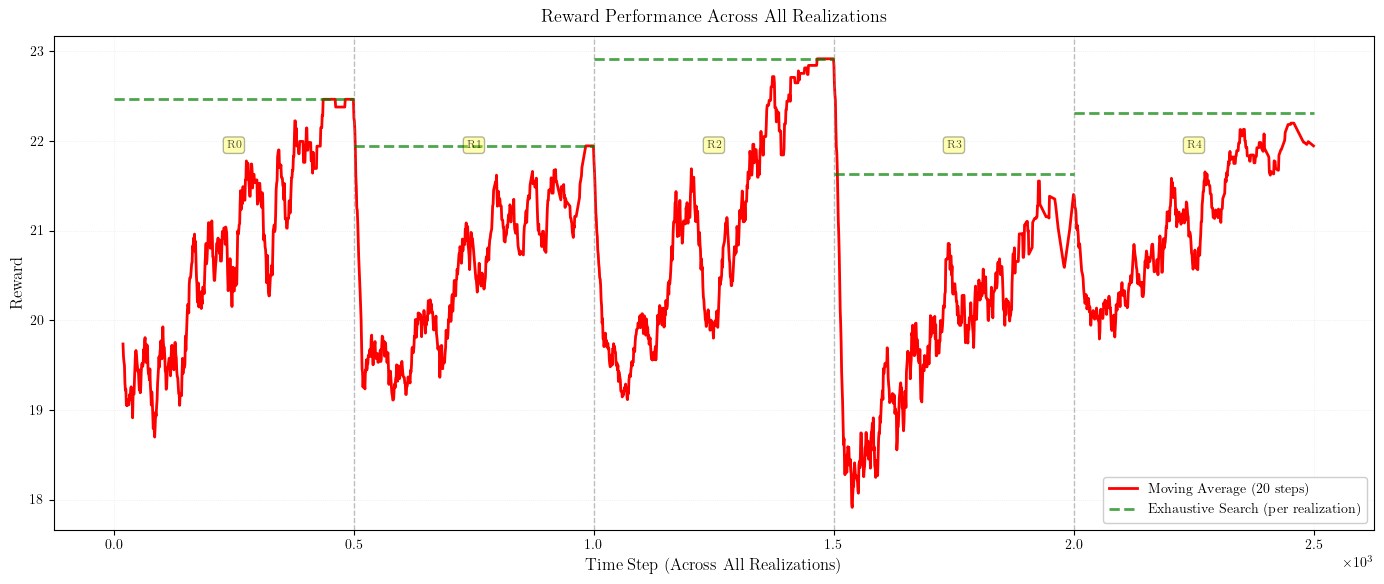

In [25]:
fig, ax1 = plt.subplots(figsize=(14, 6))


# Enable LaTeX rendering for all text

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})


# Concatenated rewards over all realizations

# Concatenate all rewards across realizations
all_rewards_concat = []
realization_boundaries = [0]

for ss in range(NUM_REALIZATIONS):
    all_rewards_concat.extend(all_realizations_log['rewards'][ss])
    realization_boundaries.append(len(all_rewards_concat))

time_steps = np.arange(len(all_rewards_concat))

# Plot moving average
window = 20
if len(all_rewards_concat) >= window:
    moving_avg = np.convolve(all_rewards_concat, np.ones(window)/window, mode='valid')
    ax1.plot(np.arange(window-1, len(all_rewards_concat)), moving_avg, 'r-', 
            linewidth=2, label=f'Moving Average ({window} steps)')

# Add vertical lines to separate realizations
for boundary in realization_boundaries[1:-1]:
    ax1.axvline(x=boundary, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Add max reward line for each realization
for ss in range(NUM_REALIZATIONS):
    max_reward = all_realizations_log['max_reward'][ss]
    start_idx = realization_boundaries[ss]
    end_idx = realization_boundaries[ss+1]
    
    ax1.hlines(y=max_reward, xmin=start_idx, xmax=end_idx, 
              colors='g', linestyles='--', linewidth=2, alpha=0.7,
              label='Exhaustive Search (per realization)' if ss == 0 else '')

ax1.set_xlabel('Time Step (Across All Realizations)', fontsize=12)
ax1.set_ylabel('Reward', fontsize=12)
ax1.set_title('Reward Performance Across All Realizations', 
              fontsize=13, pad=10, fontweight='bold')
ax1.legend(loc='lower right', framealpha=0.95, fontsize=10)
ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
ax1.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Add realization labels
for ss in range(NUM_REALIZATIONS):
    mid_point = (realization_boundaries[ss] + realization_boundaries[ss+1]) / 2
    ax1.text(mid_point, ax1.get_ylim()[1] * 0.95, f'R{ss}', 
            ha='center', va='top', fontsize=8, alpha=0.7,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.show()

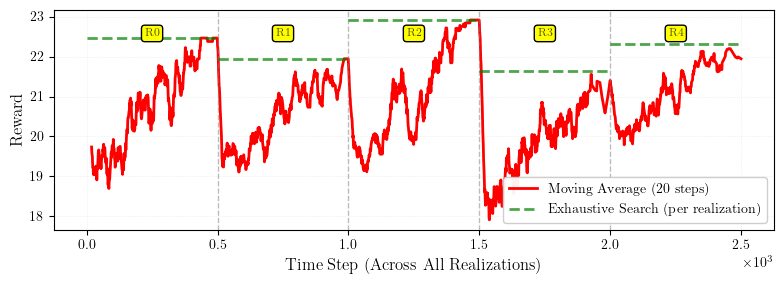

In [26]:
plt.close('all')


# Enable LaTeX rendering for all text

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})


# FIGURE 1: Reward Performance Across All Realizations

fig1, ax1 = plt.subplots(figsize=(8, 3))

all_rewards_concat = []
realization_boundaries = [0]

for ss in range(NUM_REALIZATIONS):
    all_rewards_concat.extend(all_realizations_log['rewards'][ss])
    realization_boundaries.append(len(all_rewards_concat))

time_steps = np.arange(len(all_rewards_concat))

# Plot moving average
window = 20
if len(all_rewards_concat) >= window:
    moving_avg = np.convolve(all_rewards_concat, np.ones(window)/window, mode='valid')
    ax1.plot(np.arange(window-1, len(all_rewards_concat)), moving_avg, 'r-', 
            linewidth=2, label=f'Moving Average ({window} steps)')

# Add vertical lines to separate realizations
for boundary in realization_boundaries[1:-1]:
    ax1.axvline(x=boundary, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Add max reward line for each realization
for ss in range(NUM_REALIZATIONS):
    max_reward = all_realizations_log['max_reward'][ss]
    start_idx = realization_boundaries[ss]
    end_idx = realization_boundaries[ss+1]
    ax1.hlines(y=max_reward, xmin=start_idx, xmax=end_idx, 
              colors='g', linestyles='--', linewidth=2, alpha=0.7,
              label='Exhaustive Search (per realization)' if ss == 0 else '')

ax1.set_xlabel('Time Step (Across All Realizations)', fontsize=12)
ax1.set_ylabel('Reward', fontsize=12)
# ax1.set_title('Reward Performance Across All Realizations', fontsize=13, pad=10, fontweight='bold')
ax1.legend(loc='lower right', framealpha=0.95, fontsize=10)
ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
ax1.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Add realization labels
for ss in range(NUM_REALIZATIONS):
    mid_point = (realization_boundaries[ss] + realization_boundaries[ss+1]) / 2
    ax1.text(mid_point, ax1.get_ylim()[1] * 0.98, f'R{ss}', 
            ha='center', va='top', fontsize=8, alpha=0.7,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=1.0))

plt.tight_layout()
plt.show()
fig1.savefig('fig_rewards.pdf', format='pdf', bbox_inches='tight')





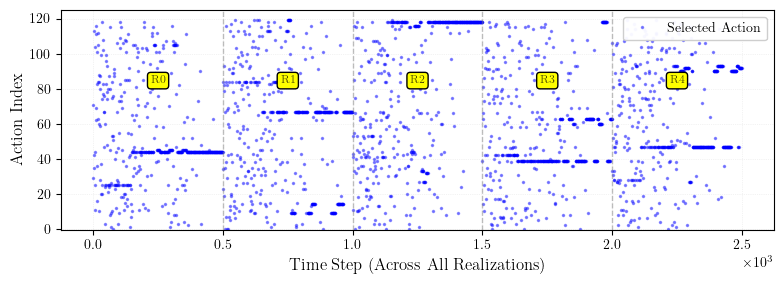

In [27]:

# FIGURE 2: Action Selection Across All Realizations

fig2, ax2 = plt.subplots(figsize=(8, 3))

ax2.plot(time_steps, all_actions_concat, 'ob', markersize=1.5, alpha=0.4, label=r'Selected Action')

for boundary in realization_boundaries[1:-1]:
    ax2.axvline(x=boundary, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax2.set_xlabel('Time Step (Across All Realizations)', fontsize=12)
ax2.set_ylabel('Action Index', fontsize=12)
# ax2.set_title('Action Selection Across All Realizations (Concatenated)', fontsize=13, pad=10, fontweight='bold')
ax2.legend(loc='upper right', framealpha=0.95, fontsize=10)
ax2.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
ax2.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
ax2.set_ylim(bottom=-0.5)

for ss in range(NUM_REALIZATIONS):
    mid_point = (realization_boundaries[ss] + realization_boundaries[ss+1]) / 2
    ax2.text(mid_point, ax2.get_ylim()[1] * 0.7, f'R{ss}', 
            ha='center', va='top', fontsize=8, alpha=0.7,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=1.0))
    # ax2.axvline(x=agent.decay_end_step, color='purple', linestyle='--', alpha=0.5,
                # label=f'95% step: {agent.decay_end_step}')

plt.tight_layout()
plt.show()
fig2.savefig('fig_actions.pdf', format='pdf', bbox_inches='tight')

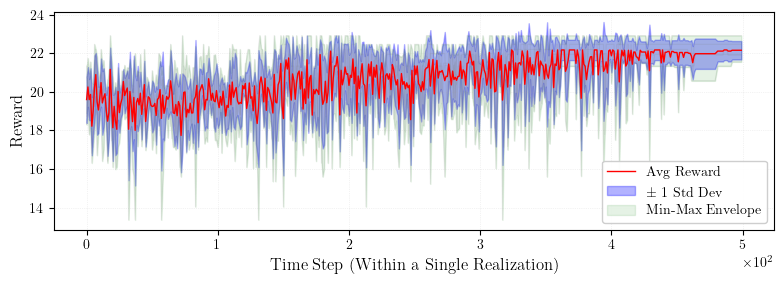

In [28]:

# PLOT : Average Over All Realizations

fig3, ax3 = plt.subplots(figsize=(8, 3))

# Find minimum length across all realizations
min_length = min([len(all_realizations_log['rewards'][i]) for i in range(NUM_REALIZATIONS)])

# Truncate all trajectories to minimum length
rewards_matrix = np.array([all_realizations_log['rewards'][i][:min_length] 
                           for i in range(NUM_REALIZATIONS)])
actions_matrix = np.array([all_realizations_log['actions'][i][:min_length] 
                          for i in range(NUM_REALIZATIONS)])

time_steps = np.arange(min_length)


# Reward subplot

# Calculate statistics
mean_rewards = np.mean(rewards_matrix, axis=0)
std_rewards = np.std(rewards_matrix, axis=0)
min_rewards = np.min(rewards_matrix, axis=0)
max_rewards_envelope = np.max(rewards_matrix, axis=0)

# Plot individual trajectories (faint)
for ss in range(NUM_REALIZATIONS):
    ax3.plot(time_steps, rewards_matrix[ss], alpha=0.15, linewidth=0.8, color='gray')

# Plot mean and confidence interval
ax3.plot(time_steps, mean_rewards, 'r-', linewidth=1, label='Avg Reward')
ax3.fill_between(time_steps, 
                  mean_rewards - std_rewards, 
                  mean_rewards + std_rewards,
                  alpha=0.3, color='blue', label='± 1 Std Dev')

# Add envelope (min/max)
ax3.fill_between(time_steps, min_rewards, max_rewards_envelope,
                  alpha=0.1, color='green', label='Min-Max Envelope')

# # Overall max reward line
# overall_max = np.max(all_realizations_log['max_reward'])
# ax3.axhline(y=overall_max, color='r', linestyle='--', linewidth=2, 
#             alpha=0.7, label=f'Overall Max: {overall_max:.2f}')

ax3.set_xlabel('Time Step (Within a Single Realization)', fontsize=12)
ax3.set_ylabel('Reward', fontsize=12)
# ax3.set_title(f'Average Reward Across All Realizations (N={NUM_REALIZATIONS})', 
            #   fontsize=13, pad=10, fontweight='bold')
ax3.legend(loc='lower right', framealpha=0.95, fontsize=10)
ax3.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
ax3.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))


plt.tight_layout()
plt.show()
fig3.savefig('fig_avg_reward.pdf', format='pdf', bbox_inches='tight')